# Analyse ERA5 demand for NEM

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import shap
shap.initjs()

import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
TIME_COLUMNS = []

In [11]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2019

In [12]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [13]:
N_FEATURES = "parsimonious"

In [14]:
DETREND = False

In [15]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load demand and climate data

In [16]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [82]:
predictions["NEM"].columns

Index(['t2max', 'msdwswrf', 't2m', 'cdd4', 'mtpr', 'hdd', 'w10', 'cdd',
       't2min', 't2m4', 't2m3', 'prediction'],
      dtype='object')

In [83]:
pred_ds[r]

<xarray.Dataset>
Dimensions:   (time: 23373)
Coordinates:
  * time      (time) datetime64[ns] 1959-01-04 1959-01-05 ... 2022-12-31
Data variables:
    t2max     (time) float64 299.9 301.6 300.4 298.2 ... 299.3 296.5 297.9 299.2
    msdwswrf  (time) float64 299.8 299.4 315.8 278.1 ... 270.1 237.4 233.1 271.8
    t2m       (time) float64 294.4 295.6 294.4 293.8 ... 293.3 292.8 294.4 295.8
    cdd4      (time) float64 0.2683 0.3254 0.4669 0.5865 ... 0.668 0.5647 0.1191
    mtpr      (time) float64 4.844e-05 5.539e-06 ... 3.032e-05 1.831e-05
    hdd       (time) float64 0.1627 0.01962 0.4513 ... 0.8727 0.1523 0.01298
    w10       (time) float64 3.163 2.373 2.615 2.632 ... 2.998 3.124 2.464 2.363
    cdd       (time) float64 0.4107 0.4989 0.6985 ... 0.08516 0.1205 0.199
    t2min     (time) float64 289.7 290.6 289.8 290.4 ... 289.5 289.5 290.6 291.4
    t2m4      (time) float64 293.1 293.9 294.4 294.6 ... 296.1 295.3 294.7 294.1
    t2m3      (time) float64 293.3 294.4 294.8 294.6 ... 296.1 294.8 293.5 294.3
    demand    (time) float64 5.335e+05 5.559e+05 ... 5.355e+05 5.533e+05

In [17]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    pred_ds[r] = ds

In [39]:
# Population density mask, remove weekends and Xmas
features = fn.read_results(
    "feature_selection", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2020, 2020,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [81]:
features["NEM"].iloc[10]

feature_idx                     (1, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15)
cv_scores            [ -9678.97848257 -10523.68488413  -9322.027561...
avg_score                                                 -9486.836979
feature_names        ['t2m3', 't2m4', 't2min', 'cdd', 'w10', 'hdd',...
ci_bound                                                    415.165062
std_dev                                                     558.984546
std_err                                                     186.328182
selected_features                                                 True
Name: 11, dtype: object

In [18]:
hyperparameters = fn.read_results(
    "hyperparameters", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2020, 2020,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

### SHAP analysis

How do the predictors contribute to the predictions for the new training period (2010-2019) and the new test period (1959-2022)?

In [19]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [29]:
dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]

In [99]:
trainX_dict = {}
testX_dict = {}

shap_train = {}
shap_test = {}

for r in regions:
    cal = fn.get_calendar(MARKET, r)
    dem = fn.remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).sel(region=r)
    pred = fn.remove_time(pred_ds[r], REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).drop(["demand", "is_workday"])
        
    train_X = pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))).to_dataframe().values
    test_X = pred.to_dataframe().values
    train_y = dem.loc[slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))].values
    
    trainX_dict[r] = train_X
    testX_dict[r] = test_X
        
    # Finalise model
    rf = ExtraTreesRegressor(
        n_estimators=int(hyperparameters[r].loc["n_estimators"].values),
        min_samples_leaf=int(hyperparameters[r].loc["min_samples_leaf"].values),
        max_depth=int(hyperparameters[r].loc["max_depth"].values),
        max_leaf_nodes=int(hyperparameters[r].loc["max_leaf_nodes"].values),
        random_state=0,
    )
    
    model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
    model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)
    
    explainer = shap.Explainer(rf)
    shap_train[r] = explainer.shap_values(train_X)
    shap_test[r] = explainer.shap_values(test_X)

In [100]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [103]:
def plot_shap(vals, features, feature_names, colorbar=True, fontsize=10):
    """
    Custom shap summary plot
    """
    pl = shap.summary_plot(
        vals,
        features,
        feature_names=feature_names,
        plot_type="dot",
        cmap="viridis",
        color_bar=colorbar,
        show=False,
        plot_size=None
    )

    ax = plt.gca()
    for pos in ["top", "bottom", "left", "right"]:
        ax.spines[pos].set_visible(True)

    # xmin = roundup(np.min(vals), 1)
    # xmax = roundup(np.max(vals), 1)
    # if xmax - xmin > 800:
        # gap = 4000
    # elif xmax - xmin > 5000:
        # gap = 1000
    # else:
        # gap = 500
#     
    # ax.set_xticks(np.arange(xmin, xmax, gap))
    ax.axes.grid(visible=True)
    ax.axvline(0, c="k")
    ax.set_xlabel("SHAP value [GWh / day]", fontsize=fontsize)
    
    ax.yaxis.label.set_size(fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)
    
    # ax.set_yticklabels(range(vals.shape[1]), labelpad=0)
    
    # fig.colorbar(pl, ax=ax)
    
    return ax

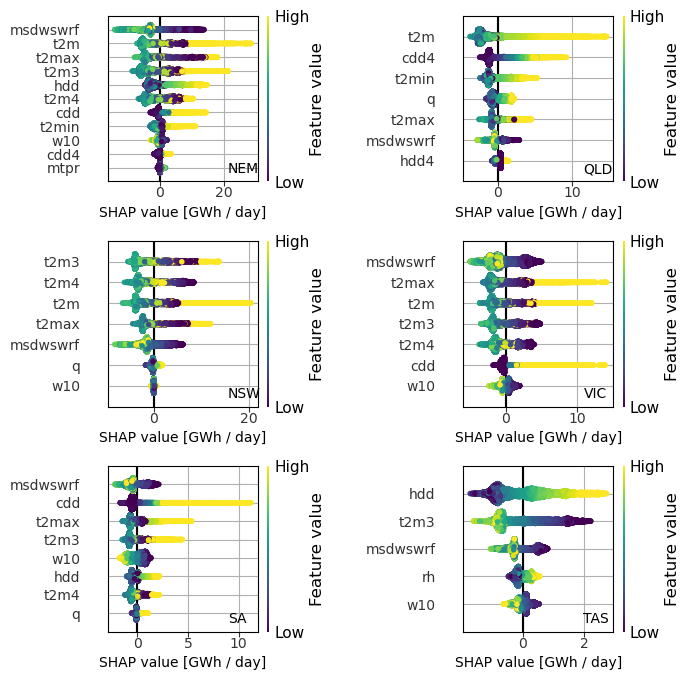

In [105]:
fig = plt.figure(figsize=(7,7))

for i, r in enumerate(regions):
    
    fig.add_subplot(3, 2, i+1)
    a = plot_shap(
        shap_test[r] / 1000,
        testX_dict[r],
        fn.parse_features(fn.sel_model(features[r])["feature_names"])[::-1]
    )
    a.text(0.8, 0.05, r, transform=a.transAxes)
    
# fig.colorbar(a, orientation='vertical')

### Compare statistics of train (2010-2019) vs test (1959-2009)

In [18]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [19]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    for hist, label, color in zip(histograms, labels, colors):
        hist.plot(ax=ax, color=color, label=label)
    ax.set_ylabel("Density [-]")
    ax.set_xlabel(xlabel)

In [20]:
first_vars = [predictions[r].columns[0] for r in regions]

In [21]:
first_vars

['t2max', 't2max', 't2max', 't2max', 't2max', 'msdwswrf']

In [22]:
first_vars_units = ["[deg C]", "[deg C]", "[deg C]", "[deg C]", "[deg C]", r"[W m$^{-2}$]"]

In [23]:
second_vars = [predictions[r].columns[1] for r in regions]
second_vars

['msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'hdd']

In [24]:
second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", "[deg C]"]

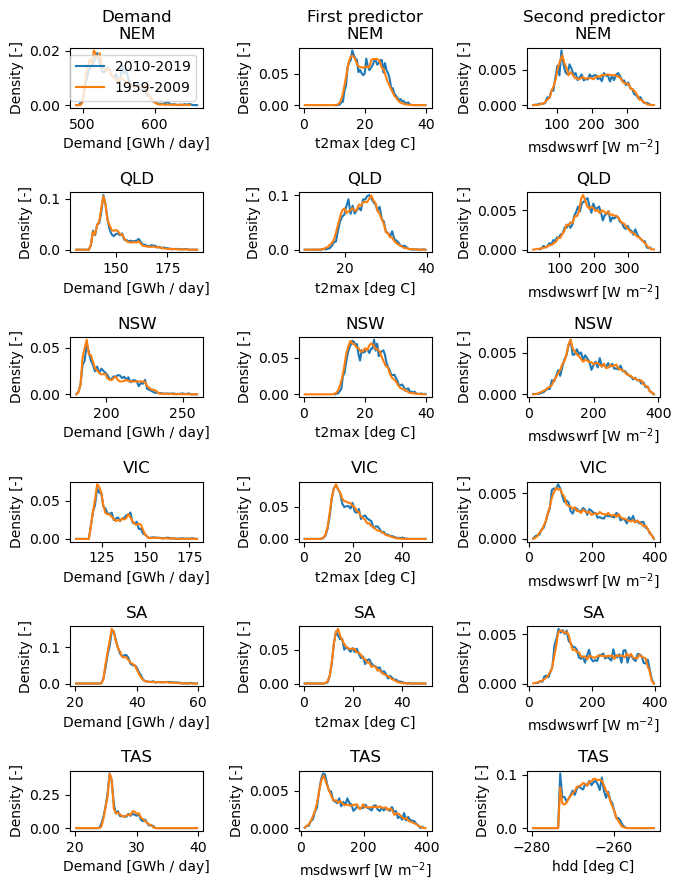

In [46]:
fig, ax = plt.subplots(6, 3, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2009")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["2010-2019", "1959-2009"], "Demand [GWh / day]")     

    # ax[i,0].text(0.02, 0.8, r, transform=ax[i,0].transAxes)
    if i == 0:
        ax[i,0].legend()

    # Most important variable histograms
    if first_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2009")) + offset)
    ]
    plot_hist(ax[i,1], hists, ["2010-2019", "1959-2009"], first_vars[i] + " " + first_vars_units[i]) 
    
    # Second most important variable histograms
    if second_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("2010", "2019")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("1959", "2009")) + offset)
    ]
    plot_hist(ax[i,2], hists, ["2010-2019", "1959-2009"], second_vars[i] + " " + second_vars_units[i]) 
    
    if i == 0:
        ax[i,0].set_title("Demand\n" + r)
        ax[i,1].set_title("First predictor\n" + r)
        ax[i,2].set_title("Second predictor\n" + r)
    else:
        ax[i,0].set_title(r)
        ax[i,1].set_title(r)
        ax[i,2].set_title(r)

plt.tight_layout()

### Time series of extreme demand days

In [47]:
def normalise(da, period=slice(None, None), dim="time"):
    """
    Normalise by removing mean and dividing by standard deviation
    """
    return (da - da.sel({dim: period}).mean(dim)) / da.sel({dim: period}).std(dim)

In [48]:
def extreme_days(da, q, period=slice(None, None), dim="time"):
    """
    Days above q, where q is computed over period
    """
    thresh = da.sel({dim: period}).quantile(q, dim)
    return da.where(da > thresh)

In [49]:
def plot_2d_series(ax, da, title):
    """
    Plot 2d time series
    """
    da.assign_coords({"region": range(6)}).plot(ax=ax)
    ax.set_yticks(range(6))
    ax.set_yticklabels(regions)
    ax.invert_yaxis()
    ax.set_title(title)

In [50]:
demand = xr.concat(
    [pred_ds[r]["demand"].expand_dims({"region": [r]}) for r in regions],
    "region"
)

In [51]:
baseline = slice("1990", "2019")

In [52]:
q = 1 - 1 / (365 * 1)
print(q)

0.9972602739726028


In [53]:
ext_dpy = extreme_days(demand, q, baseline).resample(time="1YS").count()

In [54]:
ext_dpy.sum("time")

<xarray.DataArray 'demand' (region: 6)>
array([48, 47, 54, 47, 49, 75])
Coordinates:
  * region    (region) object 'NEM' 'QLD' 'NSW' 'VIC' 'SA' 'TAS'
    quantile  float64 0.9973

In [55]:
# Normalised annual mean demand
norm_mean = normalise(demand, baseline).resample(time="1YS").mean()

In [56]:
# Normalised annual maximum demand
norm_max = normalise(demand, baseline).resample(time="1YS").max()

In [57]:
# Monthly occurrences of extreme days
monthly_ext = extreme_days(demand, q, baseline).sel(time=baseline).groupby("time.month").count()

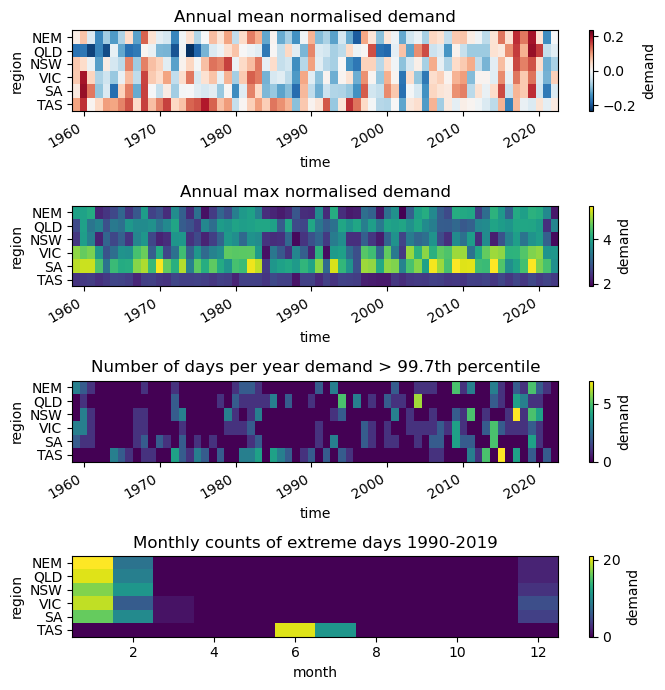

In [62]:
fig, ax = plt.subplots(4, 1, figsize=(7, 7.))

plot_2d_series(ax[0], norm_mean, "Annual mean normalised demand")
plot_2d_series(ax[1], norm_max, "Annual max normalised demand")
plot_2d_series(ax[2], ext_dpy,
               "Number of days per year demand > " + str(np.round(q*100, 1)) + "th percentile"
              )
plot_2d_series(ax[3], monthly_ext, "Monthly counts of extreme days 1990-2019")
plt.tight_layout()

### Synoptic conditions associated with extreme days

Do this only for 1990-2019, as earlier is not representative of today? E.g. TAS

Variables:
- 2m temperature
- 2m relative humidity
- MSLP
- Wind speed and direction
- Cloud cover